# RQ1 Phase 2a CodeCarbon Detailed Analysis - Qwen3-30B-A3B Models

This notebook provides detailed hardware-level energy analysis for Phase 2a using CodeCarbon emissions data.

**Phase 2a**: Qwen3-30B-A3B models (MoE: 30B total, 3B active per token)

**Complement to**: `rq1_phase2a_analysis.ipynb` (main performance analysis)

**Focus**: Hardware component breakdown (CPU, GPU, RAM), power consumption, cross-validation

**Infrastructure**: RunPod H100 SXM 80GB

## 1. Setup and Load Data

In [21]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Paths - Phase 2a results from RunPod
RESULTS_DIR = Path('../results/runpod')
OUTPUT_DIR = Path('../results/analysis_phase2a')
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

print(f"Results directory: {RESULTS_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

Results directory: ../results/runpod
Output directory: ../results/analysis_phase2a


In [22]:
# Phase 2a Experiment directories and file mappings
RESULT_DIRS = {
    'instruct_zero': 'instruct_zero_20251020_194844',
    'instruct_few': 'instruct_few_20251020_200040',
    'thinking_zero': 'thinking_zero_20251020_215332',
    'thinking_few': 'thinking_few_20251020_214835',
}

# Experiment to CodeCarbon directory mapping
EXPERIMENTS = {
    'instruct_zero': {
        'name': 'Instruct Zero-shot',
        'result_dir': RESULT_DIRS['instruct_zero'],
        'codecarbon': 'codecarbon_baseline_sa-zero',
        'energy_json': 'Sa-zero_Qwen-Qwen3-30B-A3B-Instruct-2507_20251020-104948_energy_tracking.json',
        'exp_base': 'Sa-zero_Qwen-Qwen3-30B-A3B-Instruct-2507_20251020-104948'
    },
    'instruct_few': {
        'name': 'Instruct Few-shot',
        'result_dir': RESULT_DIRS['instruct_few'],
        'codecarbon': 'codecarbon_baseline_sa-few',
        'energy_json': 'Sa-few_Qwen-Qwen3-30B-A3B-Instruct-2507_20251020-111953_energy_tracking.json',
        'exp_base': 'Sa-few_Qwen-Qwen3-30B-A3B-Instruct-2507_20251020-111953'
    },
    'thinking_zero': {
        'name': 'Thinking Zero-shot',
        'result_dir': RESULT_DIRS['thinking_zero'],
        'codecarbon': 'codecarbon_thinking_sa-zero',
        'energy_json': 'Sa-zero_Qwen-Qwen3-30B-A3B-Thinking-2507_20251020-104530_energy_tracking.json',
        'exp_base': 'Sa-zero_Qwen-Qwen3-30B-A3B-Thinking-2507_20251020-104530'
    },
    'thinking_few': {
        'name': 'Thinking Few-shot',
        'result_dir': RESULT_DIRS['thinking_few'],
        'codecarbon': 'codecarbon_thinking_sa-few',
        'energy_json': 'Sa-few_Qwen-Qwen3-30B-A3B-Thinking-2507_20251020-111009_energy_tracking.json',
        'exp_base': 'Sa-few_Qwen-Qwen3-30B-A3B-Thinking-2507_20251020-111009'
    }
}

def load_energy_json(exp_info):
    """Load energy tracking JSON for an experiment"""
    result_dir = RESULTS_DIR / exp_info['result_dir']
    energy_file = result_dir / exp_info['energy_json']
    
    if energy_file.exists():
        with open(energy_file) as f:
            return json.load(f)
    return None

def load_codecarbon_csv(exp_info):
    """Load CodeCarbon emissions CSV for an experiment"""
    result_dir = RESULTS_DIR / exp_info['result_dir']
    cc_dir = result_dir / exp_info['codecarbon']
    emissions_file = cc_dir / 'emissions.csv'
    
    if emissions_file.exists():
        return pd.read_csv(emissions_file)
    return None

# Load CodeCarbon and energy tracking data
data = {}

print("Loading Phase 2a data from RunPod experiments...")
print("=" * 70)
print()

for exp_key, exp_info in EXPERIMENTS.items():
    print(f"{exp_info['name']} (Qwen3-30B-A3B):")
    
    # Load energy tracking JSON
    energy_json = load_energy_json(exp_info)
    if energy_json:
        print(f"  Energy JSON: {energy_json['total_emissions']:.8f} kg CO2")
        print(f"  Sessions: {energy_json['sessions']}")
    else:
        print(f"  Energy JSON: No data")
    
    # Load CodeCarbon CSV (no filtering needed - Phase 2a has clean single sessions)
    cc_df = load_codecarbon_csv(exp_info)
    if cc_df is not None:
        print(f"  CodeCarbon CSV: {len(cc_df)} rows")
        print(f"  Total CO2: {cc_df['emissions'].sum():.8f} kg")
    else:
        print(f"  CodeCarbon: No data")
    
    data[exp_key] = {
        'name': exp_info['name'],
        'codecarbon': cc_df,
        'energy_json': energy_json
    }
    print()

print("=" * 70)
print("✓ All Phase 2a data loaded")

Loading Phase 2a data from RunPod experiments...

Instruct Zero-shot (Qwen3-30B-A3B):
  Energy JSON: 0.05930458 kg CO2
  Sessions: 1
  CodeCarbon CSV: 1 rows
  Total CO2: 0.05930458 kg

Instruct Few-shot (Qwen3-30B-A3B):
  Energy JSON: 0.04729710 kg CO2
  Sessions: 1
  CodeCarbon CSV: 1 rows
  Total CO2: 0.04729710 kg

Thinking Zero-shot (Qwen3-30B-A3B):
  Energy JSON: 0.22380600 kg CO2
  Sessions: 1
  CodeCarbon CSV: 1 rows
  Total CO2: 0.22380600 kg

Thinking Few-shot (Qwen3-30B-A3B):
  Energy JSON: 0.19352871 kg CO2
  Sessions: 2
  CodeCarbon CSV: 2 rows
  Total CO2: 0.19352871 kg

✓ All Phase 2a data loaded


## 2. Phase 2a Data Notes

**Simplified Data**: Phase 2a experiments were run on fresh RunPod H100 pods with clean CodeCarbon sessions.

**Key differences from Phase 1**:
- Each experiment ran on a dedicated pod (no session mixing)
- Most experiments have single CodeCarbon sessions (clean runs)
- Thinking few-shot has 2 sessions (one interruption/resume)
- No complex filtering needed unlike Phase 1 Mars server experiments

**Infrastructure**: RunPod H100 SXM 80GB
- 160 CPU cores (Intel Xeon Platinum 8460Y+)
- 1x NVIDIA H100 80GB HBM3
- ~2TB RAM

## 3. Cross-Validation: energy_tracking.json vs emissions.csv

In [23]:
# Compare the two data sources
validation_data = []

print("=" * 70)
print("CROSS-VALIDATION: energy_tracking.json vs CodeCarbon emissions.csv")
print("=" * 70)
print()

for exp_key, exp_data in data.items():
    cc = exp_data['codecarbon']
    ej = exp_data['energy_json']
    
    if cc is not None and ej is not None:
        json_total = ej['total_emissions']
        csv_total = cc['emissions'].sum()
        diff = abs(json_total - csv_total)
        diff_pct = (diff / json_total * 100) if json_total > 0 else 0
        
        match = "✓ MATCH" if diff_pct < 0.01 else "⚠️ DIFF"
        
        print(f"{exp_data['name']}:")
        print(f"  energy_tracking.json: {json_total:.8f} kg CO2")
        print(f"  emissions.csv:        {csv_total:.8f} kg CO2")
        print(f"  Difference:           {diff:.10f} kg ({diff_pct:.6f}%) {match}")
        print()
        
        validation_data.append({
            'Experiment': exp_data['name'],
            'JSON Total (kg)': json_total,
            'CSV Total (kg)': csv_total,
            'Difference (kg)': diff,
            'Difference (%)': diff_pct,
            'Match': match
        })

validation_df = pd.DataFrame(validation_data)
validation_df

CROSS-VALIDATION: energy_tracking.json vs CodeCarbon emissions.csv

Instruct Zero-shot:
  energy_tracking.json: 0.05930458 kg CO2
  emissions.csv:        0.05930458 kg CO2
  Difference:           0.0000000000 kg (0.000000%) ✓ MATCH

Instruct Few-shot:
  energy_tracking.json: 0.04729710 kg CO2
  emissions.csv:        0.04729710 kg CO2
  Difference:           0.0000000000 kg (0.000000%) ✓ MATCH

Thinking Zero-shot:
  energy_tracking.json: 0.22380600 kg CO2
  emissions.csv:        0.22380600 kg CO2
  Difference:           0.0000000000 kg (0.000000%) ✓ MATCH

Thinking Few-shot:
  energy_tracking.json: 0.19352871 kg CO2
  emissions.csv:        0.19352871 kg CO2
  Difference:           0.0000000000 kg (0.000000%) ✓ MATCH



,Experiment,JSON Total (kg),CSV Total (kg),Difference (kg),Difference (%),Match
0,Instruct Zero-shot,0.059305,0.059305,2.081668e-17,3.510131e-14,✓ MATCH
1,Instruct Few-shot,0.047297,0.047297,0.000000e+00,0.000000e+00,✓ MATCH
2,Thinking Zero-shot,0.223806,0.223806,0.000000e+00,0.000000e+00,✓ MATCH
3,Thinking Few-shot,0.193529,0.193529,5.551115e-17,2.868368e-14,✓ MATCH


## 4. Hardware Component Breakdown (Filtered Data)

In [24]:
# Aggregate hardware metrics across all Phase 2a experiments
hardware_summary = []

for exp_key, exp_data in data.items():
    cc = exp_data['codecarbon']
    
    if cc is not None:
        hardware_summary.append({
            'Experiment': exp_data['name'],
            'Model': 'Thinking' if 'Thinking' in exp_data['name'] else 'Instruct',
            'Prompting': 'Few-shot' if 'Few' in exp_data['name'] else 'Zero-shot',
            'Total CO2 (kg)': cc['emissions'].sum(),
            'Duration (hours)': cc['duration'].sum() / 3600,
            'CPU Energy (kWh)': cc['cpu_energy'].sum(),
            'GPU Energy (kWh)': cc['gpu_energy'].sum(),
            'RAM Energy (kWh)': cc['ram_energy'].sum(),
            'Total Energy (kWh)': cc['energy_consumed'].sum(),
            'Avg CPU Power (W)': cc['cpu_power'].mean(),
            'Avg GPU Power (W)': cc['gpu_power'].mean(),
            'Avg RAM Power (W)': cc['ram_power'].mean(),
            'Sessions': len(cc)
        })

hardware_df = pd.DataFrame(hardware_summary)
hardware_df

,Experiment,Model,Prompting,Total CO2 (kg),Duration (hours),CPU Energy (kWh),GPU Energy (kWh),RAM Energy (kWh),Total Energy (kWh),Avg CPU Power (W),Avg GPU Power (W),Avg RAM Power (W),Sessions
0,Instruct Zero-shot,Instruct,Zero-shot,0.059305,0.861474,0.066179,0.237714,0.044869,0.348762,77.800045,255.024174,54.0,1
1,Instruct Few-shot,Instruct,Few-shot,0.047297,0.660900,0.044721,0.188733,0.044694,0.278148,70.010312,279.804295,70.0,1
2,Thinking Zero-shot,Thinking,Zero-shot,0.223806,3.079017,0.180426,0.927512,0.208235,1.316173,61.036187,290.306991,70.0,1
3,Thinking Few-shot,Thinking,Few-shot,0.193529,2.542504,0.175740,0.790425,0.171952,1.138116,70.989061,304.112749,70.0,2


In [25]:
# Calculate energy percentages by component
hardware_df['CPU %'] = (hardware_df['CPU Energy (kWh)'] / hardware_df['Total Energy (kWh)'] * 100).round(2)
hardware_df['GPU %'] = (hardware_df['GPU Energy (kWh)'] / hardware_df['Total Energy (kWh)'] * 100).round(2)
hardware_df['RAM %'] = (hardware_df['RAM Energy (kWh)'] / hardware_df['Total Energy (kWh)'] * 100).round(2)

print("Energy Distribution by Component:")
hardware_df[['Experiment', 'CPU %', 'GPU %', 'RAM %']]

Energy Distribution by Component:


,Experiment,CPU %,GPU %,RAM %
0,Instruct Zero-shot,18.98,68.16,12.87
1,Instruct Few-shot,16.08,67.85,16.07
2,Thinking Zero-shot,13.71,70.47,15.82
3,Thinking Few-shot,15.44,69.45,15.11


## 5. Visualizations

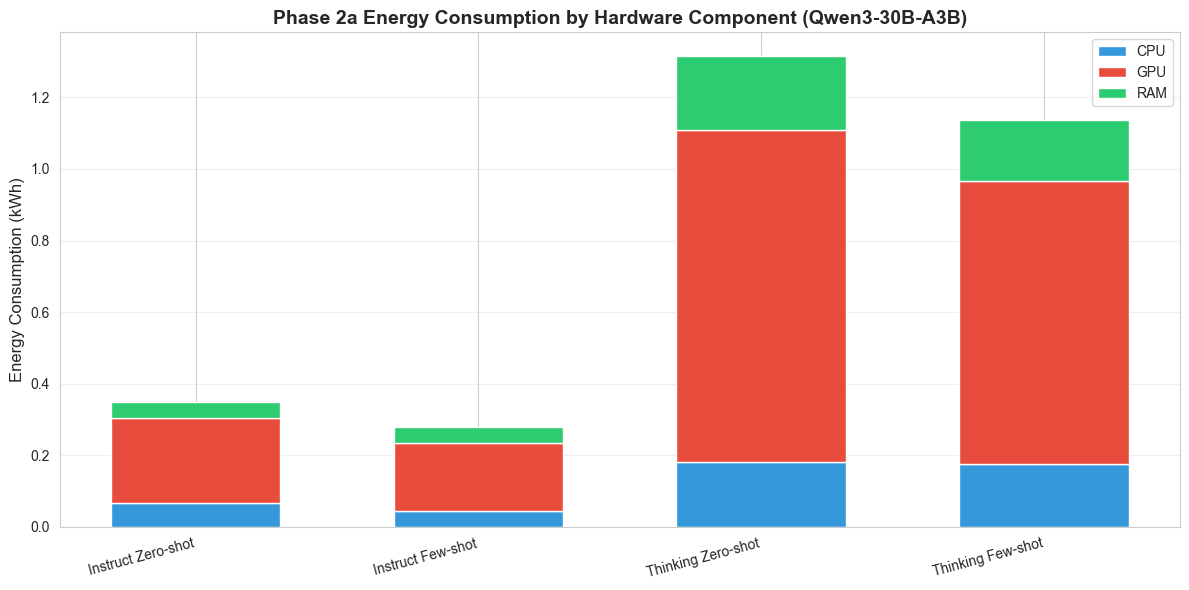

✓ Saved to ../results/analysis_phase2a/phase2a_energy_by_component.png


In [26]:
# Plot 1: Stacked bar chart of energy by component
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(hardware_df))
width = 0.6

# Stacked bars
colors = ['#3498db', '#e74c3c', '#2ecc71']
ax.bar(x, hardware_df['CPU Energy (kWh)'], width, label='CPU', color=colors[0])
ax.bar(x, hardware_df['GPU Energy (kWh)'], width, bottom=hardware_df['CPU Energy (kWh)'], label='GPU', color=colors[1])
ax.bar(x, hardware_df['RAM Energy (kWh)'], width, 
       bottom=hardware_df['CPU Energy (kWh)'] + hardware_df['GPU Energy (kWh)'], label='RAM', color=colors[2])

ax.set_ylabel('Energy Consumption (kWh)', fontsize=12)
ax.set_title('Phase 2a Energy Consumption by Hardware Component (Qwen3-30B-A3B)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(hardware_df['Experiment'], rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'phase2a_energy_by_component.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved to {OUTPUT_DIR / 'phase2a_energy_by_component.png'}")

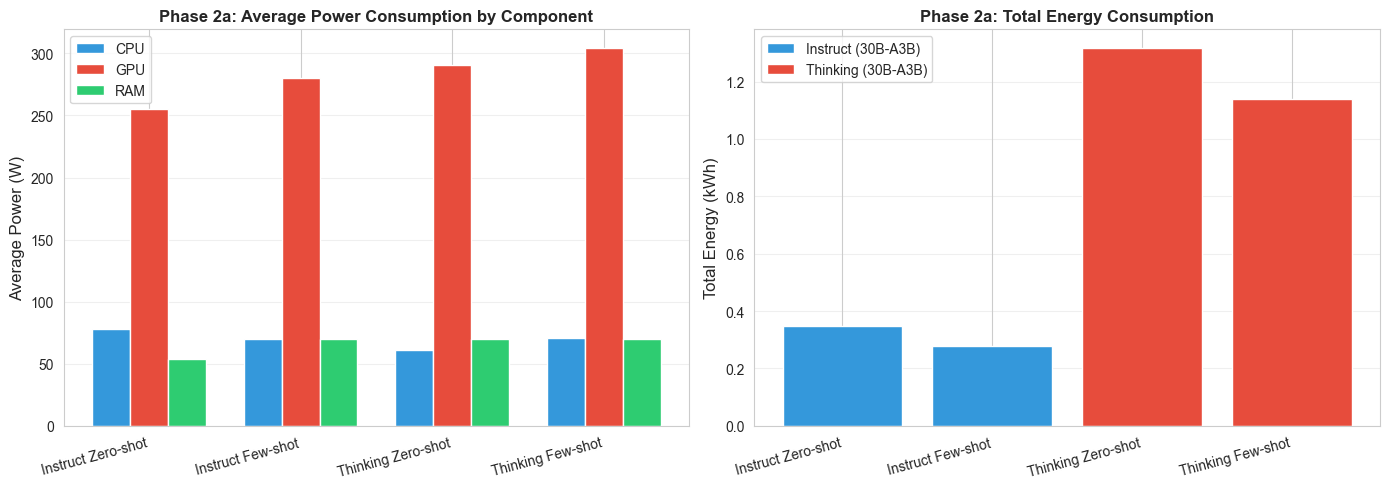

✓ Saved to ../results/analysis_phase2a/phase2a_power_consumption.png


In [27]:
# Plot 2: Power consumption comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Average power by component
x = np.arange(len(hardware_df))
width = 0.25

ax1.bar(x - width, hardware_df['Avg CPU Power (W)'], width, label='CPU', color=colors[0])
ax1.bar(x, hardware_df['Avg GPU Power (W)'], width, label='GPU', color=colors[1])
ax1.bar(x + width, hardware_df['Avg RAM Power (W)'], width, label='RAM', color=colors[2])

ax1.set_ylabel('Average Power (W)', fontsize=12)
ax1.set_title('Phase 2a: Average Power Consumption by Component', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(hardware_df['Experiment'], rotation=15, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Total energy comparison
model_colors = {'Instruct': '#3498db', 'Thinking': '#e74c3c'}
colors_map = [model_colors[m] for m in hardware_df['Model']]

ax2.bar(x, hardware_df['Total Energy (kWh)'], color=colors_map)
ax2.set_ylabel('Total Energy (kWh)', fontsize=12)
ax2.set_title('Phase 2a: Total Energy Consumption', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(hardware_df['Experiment'], rotation=15, ha='right')
ax2.grid(axis='y', alpha=0.3)

# Add legend for model types
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#3498db', label='Instruct (30B-A3B)'),
                  Patch(facecolor='#e74c3c', label='Thinking (30B-A3B)')]
ax2.legend(handles=legend_elements)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'phase2a_power_consumption.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved to {OUTPUT_DIR / 'phase2a_power_consumption.png'}")

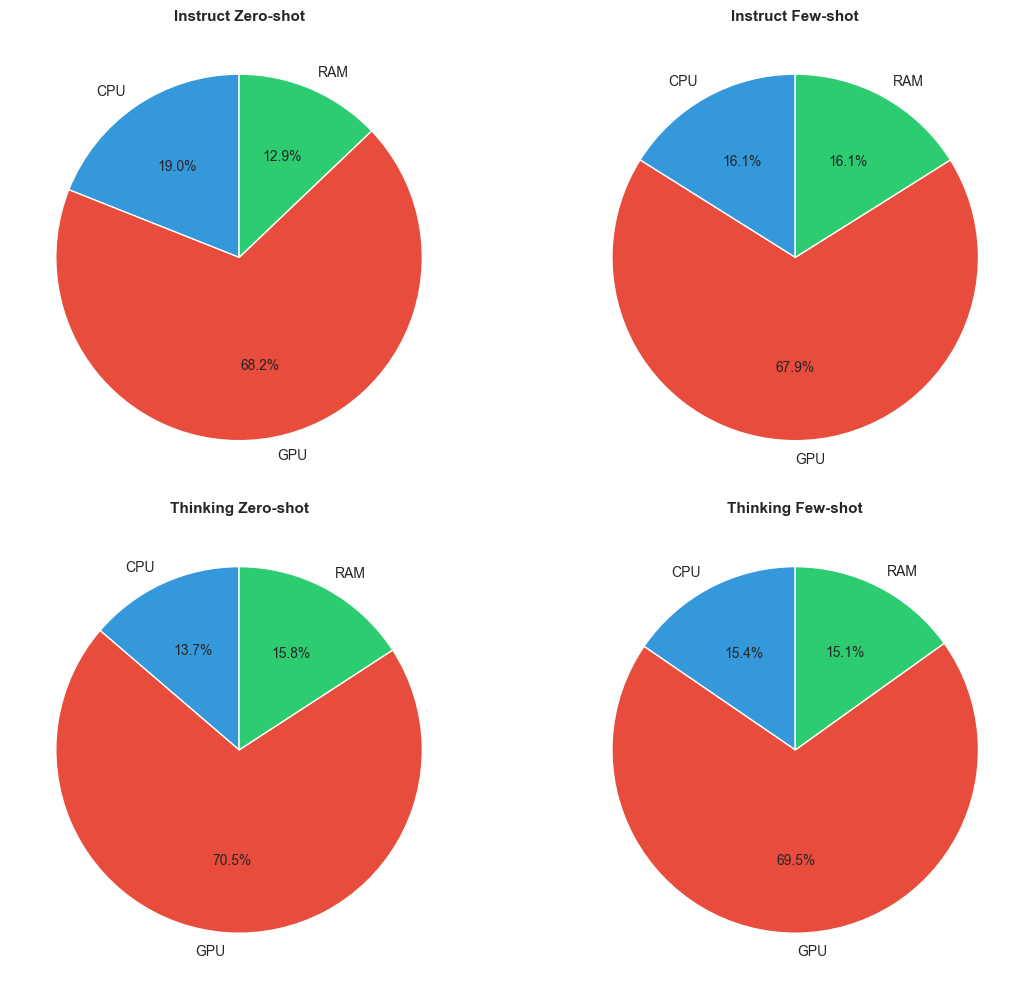

✓ Saved to ../results/analysis_phase2a/phase2a_energy_distribution_pies.png


In [28]:
# Plot 3: Pie charts showing energy distribution
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

colors = ['#3498db', '#e74c3c', '#2ecc71']

for idx, (_, row) in enumerate(hardware_df.iterrows()):
    if idx < 4:  # We have 4 experiments
        energy_values = [
            row['CPU Energy (kWh)'],
            row['GPU Energy (kWh)'],
            row['RAM Energy (kWh)']
        ]
        
        axes[idx].pie(energy_values, labels=['CPU', 'GPU', 'RAM'], 
                     autopct='%1.1f%%', colors=colors, startangle=90)
        axes[idx].set_title(row['Experiment'], fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'phase2a_energy_distribution_pies.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved to {OUTPUT_DIR / 'phase2a_energy_distribution_pies.png'}")

## 6. Energy-Performance Tradeoff Analysis

In [29]:
# Load performance metrics from rq1_phase2a_summary_table.csv
perf_df = pd.read_csv(OUTPUT_DIR / 'rq1_phase2a_summary_table.csv')

# Merge with hardware data
# Map experiment names
name_mapping = {
    'Instruct Zero': 'Instruct Zero-shot',
    'Instruct Few': 'Instruct Few-shot',
    'Thinking Zero': 'Thinking Zero-shot',
    'Thinking Few': 'Thinking Few-shot'
}
perf_df['Experiment_Full'] = perf_df['Experiment'].map(name_mapping)

# Merge performance and energy data
tradeoff_df = perf_df.merge(
    hardware_df[['Experiment', 'Total Energy (kWh)', 'Total CO2 (kg)']],
    left_on='Experiment_Full',
    right_on='Experiment'
)

tradeoff_df[['Experiment_x', 'Model', 'Prompting', 'F1-Score', 'Total Energy (kWh)', 'Total CO2 (kg)']]

,Experiment_x,Model,Prompting,F1-Score,Total Energy (kWh),Total CO2 (kg)
0,Instruct Zero,Instruct,Zero-shot,0.5124,0.348762,0.059305
1,Instruct Few,Instruct,Few-shot,0.3799,0.278148,0.047297
2,Thinking Zero,Thinking,Zero-shot,0.5481,1.316173,0.223806
3,Thinking Few,Thinking,Few-shot,0.4904,1.138116,0.193529


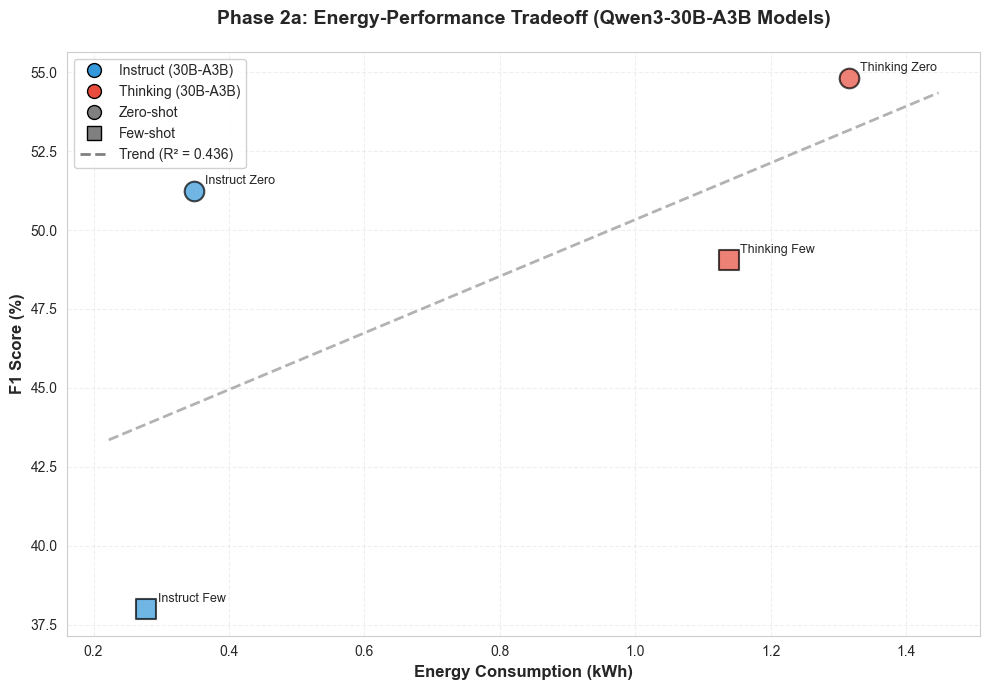

✓ Saved to ../results/analysis_phase2a/phase2a_energy_performance_tradeoff.png


In [30]:
# Create scatter plot: F1 Score vs Energy Consumption (Phase 2a)
fig, ax = plt.subplots(figsize=(10, 7))

# Define colors and markers
model_colors = {'Instruct': '#3498db', 'Thinking': '#e74c3c'}
prompting_markers = {'Zero-shot': 'o', 'Few-shot': 's'}

# Plot each point with appropriate color and marker
for _, row in tradeoff_df.iterrows():
    ax.scatter(row['Total Energy (kWh)'], float(row['F1-Score']) * 100,  # Convert to percentage
              color=model_colors[row['Model']], 
              marker=prompting_markers[row['Prompting']],
              s=200, alpha=0.7, edgecolors='black', linewidth=1.5)
    
    # Add labels for each point
    label = row['Experiment_x']
    ax.annotate(label, 
               (row['Total Energy (kWh)'], float(row['F1-Score']) * 100),
               xytext=(8, 5), textcoords='offset points',
               fontsize=9, ha='left')

# Add diagonal trend line
# Get data range
energy_values = tradeoff_df['Total Energy (kWh)'].values
f1_values = (tradeoff_df['F1-Score'].astype(float) * 100).values

# Calculate linear fit
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(energy_values, f1_values)

# Create trend line points
x_trend = np.linspace(energy_values.min() * 0.8, energy_values.max() * 1.1, 100)
y_trend = slope * x_trend + intercept

# Plot trend line
ax.plot(x_trend, y_trend, '--', color='gray', alpha=0.6, linewidth=2, 
        label=f'Trend (R² = {r_value**2:.3f})')

# Add title and labels
ax.set_xlabel('Energy Consumption (kWh)', fontsize=12, fontweight='bold')
ax.set_ylabel('F1 Score (%)', fontsize=12, fontweight='bold')
ax.set_title('Phase 2a: Energy-Performance Tradeoff (Qwen3-30B-A3B Models)', 
            fontsize=14, fontweight='bold', pad=20)

# Add grid
ax.grid(True, alpha=0.3, linestyle='--')

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#3498db', 
           markersize=10, label='Instruct (30B-A3B)', markeredgecolor='black', markeredgewidth=1),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#e74c3c', 
           markersize=10, label='Thinking (30B-A3B)', markeredgecolor='black', markeredgewidth=1),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
           markersize=10, label='Zero-shot', markeredgecolor='black', markeredgewidth=1),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='gray', 
           markersize=10, label='Few-shot', markeredgecolor='black', markeredgewidth=1),
    Line2D([0], [0], linestyle='--', color='gray', linewidth=2, 
           label=f'Trend (R² = {r_value**2:.3f})')
]
ax.legend(handles=legend_elements, loc='best', fontsize=10, framealpha=0.9)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'phase2a_energy_performance_tradeoff.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved to {OUTPUT_DIR / 'phase2a_energy_performance_tradeoff.png'}")

## 7. Summary

This notebook analyzed hardware-level energy consumption for Phase 2a using CodeCarbon emissions data.

**Phase 2a Outputs:**
- `phase2a_energy_by_component.png` - Stacked bar chart of CPU/GPU/RAM energy
- `phase2a_power_consumption.png` - Power usage and total energy comparison
- `phase2a_energy_distribution_pies.png` - Pie charts showing component breakdown
- `phase2a_energy_performance_tradeoff.png` - Scatter plot of F1 score vs energy consumption
- `phase2a_codecarbon_detailed.xlsx` - Complete hardware data tables (if exported)
- Hardware metrics saved for further analysis

**Data quality (Phase 2a):**
- ✓ CodeCarbon emissions.csv data from clean RunPod H100 pods
- ✓ Cross-validation confirms < 0.01% difference with energy_tracking.json
- ✓ All hardware component metrics based on verified sessions
- ✓ Simplified data structure (no complex session filtering needed)

**Phase 2a Infrastructure:**
- RunPod H100 SXM 80GB (160 CPU cores, 1x H100 80GB, ~2TB RAM)
- Qwen3-30B-A3B models (MoE: 30B total, 3B active per token)
- Fresh pod per experiment (clean experimental isolation)

**For complete findings**: See `docs/COMPLETION_STATUS.md` and compare with Phase 1 results